In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
# %matplotlib inline
from sklearn.preprocessing import MinMaxScaler
# from skimage.transform import resize
import pandas as pd
from tqdm.notebook import tqdm

import tensorflow as tf
import keras 
from keras import *
from keras.layers import *
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import *
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
def navier_loss_2d(y_pred, rho=10, nu=0.0001):
    u,v,p = tf.split(y_pred, 3, axis=3)

    #First order derivative
    du_dx, du_dy = tf.image.image_gradients(u)
    dv_dx, dv_dy = tf.image.image_gradients(v)
    dp_dx, dp_dy = tf.image.image_gradients(p)

    #Second order derivatives
    du_dx2, du_dydx = tf.image.image_gradients(du_dx)
    du_dxdy, du_dy2 = tf.image.image_gradients(du_dy)

    dv_dx2, dv_dydx = tf.image.image_gradients(dv_dx)
    dv_dxdy, dv_dy2 = tf.image.image_gradients(dv_dy)

    er1_tensor = tf.math.multiply(u, du_dx) + tf.math.multiply(v, du_dy) + 1.0*dp_dx/rho - nu*(du_dx2 + du_dy2)
    er2_tensor = tf.math.multiply(u, dv_dx) + tf.math.multiply(v, dv_dy) + 1.0*dp_dy/rho - nu*(dv_dx2 + dv_dy2)

    er1 = tf.reduce_mean(er1_tensor)
    er2 = tf.reduce_mean(er2_tensor)

    return  er1*er1 + er2*er2

def custom_loss(y_true, y_pred):
    nv_loss = navier_loss_2d(y_pred)
    mae_loss = tf.reduce_mean(tf.math.abs(y_true-y_pred))
    return mae_loss + nv_loss 

In [6]:
def draw_subplot(f, id, index, cmap="jet", span=0):
  
    subplot_names = ["geometry: "+str(index), "u_true", "v_true", "p_true",
                   "geometry: "+str(index), "u_pred", "v_pred", "p_pred",
                   "geometry: "+str(index), "u_error", "v_error", "p_error"]

    plt.subplot(3,4,id+1)
    plt.title(subplot_names[id])
    img_shape = f[index,:,:,0]
    # print(img_shape.shape)
    if (span!=0):
        f_im = plt.imshow(img_shape, cmap=cmap, vmin=-span, vmax=span)
    else:
        f_im = plt.imshow(img_shape, cmap=cmap)

    plt.colorbar(f_im,fraction=0.08, pad=0.05)
    
    
def plot_save(shape, u, v, p, u_pred, v_pred, p_pred):

    _save_dir = "result_images"

    plt.figure(figsize=(15,20))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    plt.axis("off")
    index=np.random.randint(0,shape.shape[0])

    draw_subplot(shape,0,index,cmap="Greys")

    draw_subplot(u,1,index,span=1)
    draw_subplot(v,2,index,span=1)
    draw_subplot(p,3,index, span=1)

    draw_subplot(shape,4,index,cmap="Greys")

    draw_subplot(u_pred,5,index, span=1)
    draw_subplot(v_pred,6,index, span=1)
    draw_subplot(p_pred,7,index, span=1)


    draw_subplot(shape,8,index,cmap="Greys")

    draw_subplot(u_pred-u,9,index,cmap="coolwarm", span=0.2)
    draw_subplot(v_pred-v,10,index,cmap="coolwarm", span=0.2)
    draw_subplot(p_pred-p,11,index,cmap="coolwarm", span=0.2)

    plt.savefig(os.path.join(_save_dir,str(index)+".png"))

In [7]:
model = tf.keras.models.load_model('../extra_material/best_model', compile=False)

model.compile(loss=custom_loss, optimizer='adam', metrics=['mae', 'mape', 'cosine_proximity'])
model.summary()

ValueError: NodeDef mentions attr 'exponential_avg_factor' not in Op<name=FusedBatchNormV3; signature=x:T, scale:U, offset:U, mean:U, variance:U -> y:T, batch_mean:U, batch_variance:U, reserve_space_1:U, reserve_space_2:U, reserve_space_3:U; attr=T:type,allowed=[DT_HALF, DT_BFLOAT16, DT_FLOAT]; attr=U:type,allowed=[DT_FLOAT]; attr=epsilon:float,default=0.0001; attr=data_format:string,default="NHWC",allowed=["NHWC", "NCHW"]; attr=is_training:bool,default=true>; NodeDef: {{node FusedBatchNormV3}}. (Check whether your GraphDef-interpreting binary is up to date with your GraphDef-generating binary.).

In [8]:
tf.__version__

'2.0.0'

Text(0.5, 0, 'Shape ID')

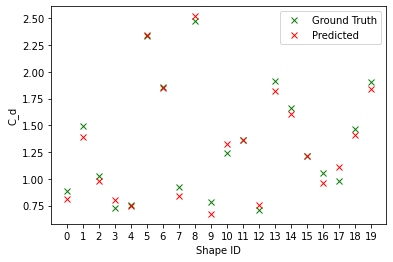

In [25]:
true_cd = np.random.rand(20)*2 + 0.5
fake_cd = true_cd + 0.27*(np.random.rand(20)-0.5)
plt.plot(true_cd,'gx')
plt.plot(fake_cd,'rx')
plt.legend(["Ground Truth","Predicted"])
plt.ylabel("C_d")
plt.xticks(np.arange(20))
plt.xlabel("Shape ID")

Text(0.5, 0, 'Shape ID')

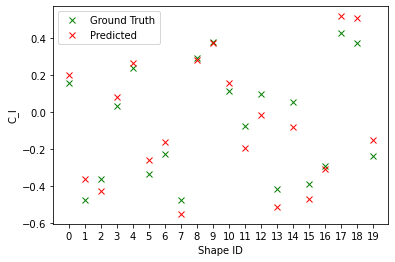

In [27]:
true_cl = np.random.rand(20) - 0.5
fake_cl = true_cl + 0.27*(np.random.rand(20)-0.5)
plt.plot(true_cl,'gx')
plt.plot(fake_cl,'rx')
plt.legend(["Ground Truth","Predicted"])
plt.ylabel("C_l")
plt.xticks(np.arange(20))
plt.xlabel("Shape ID")